### import the used libraries

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, make_scorer, precision_score, recall_score, f1_score, ConfusionMatrixDisplay
import seaborn as sns
import math

### first i read the dataset and take a copy of it

In [73]:
df = pd.read_csv('loan_data.csv')
mod_df=df.copy()

In [74]:
mod_df

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44995,27.0,male,Associate,47971.0,6,RENT,15000.0,MEDICAL,15.66,0.31,3.0,645,No,1
44996,37.0,female,Associate,65800.0,17,RENT,9000.0,HOMEIMPROVEMENT,14.07,0.14,11.0,621,No,1
44997,33.0,male,Associate,56942.0,7,RENT,2771.0,DEBTCONSOLIDATION,10.02,0.05,10.0,668,No,1
44998,29.0,male,Bachelor,33164.0,4,RENT,12000.0,EDUCATION,13.23,0.36,6.0,604,No,1


### The maximum age value of 144 is an outlier, as it isn't a reasonable. To handle this, we removed Outliers : Remove ages above a certain threshold, like who are greater than 100 years, to make it more reasonable.

In [75]:
max_Age = mod_df['person_age'].max()
print("Maximum value of column A:", max_Age)

Maximum value of column A: 144.0


In [76]:
mod_df = mod_df[mod_df['person_age'] <= 100]

### transform the string categorical columns using label encoding to use for KNN

In [77]:

mod_df['person_gender'] = LabelEncoder().fit_transform(mod_df['person_gender'])
mod_df['loan_intent'] = LabelEncoder().fit_transform(mod_df['loan_intent'])
mod_df['person_home_ownership'] = LabelEncoder().fit_transform(mod_df['person_home_ownership'])
mod_df['person_education'] = LabelEncoder().fit_transform(mod_df['person_education'])
mod_df['previous_loan_defaults_on_file'] = LabelEncoder().fit_transform(mod_df['previous_loan_defaults_on_file'])


C:\Users\Mega Store\AppData\Local\Temp\ipykernel_23540\3123257307.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df['person_gender'] = LabelEncoder().fit_transform(mod_df['person_gender'])
C:\Users\Mega Store\AppData\Local\Temp\ipykernel_23540\3123257307.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mod_df['loan_intent'] = LabelEncoder().fit_transform(mod_df['loan_intent'])
C:\Users\Mega Store\AppData\Local\Temp\ipykernel_23540\3123257307.py:3: SettingWithCopyWarning: 
A value is trying to be

### define x as independent variables and y as output/label/target

In [78]:
X = mod_df.iloc[:, :-1].values
y = mod_df.iloc[:, -1].values

In [79]:
X

array([[ 22.,   0.,   4., ...,   3., 561.,   0.],
       [ 21.,   0.,   3., ...,   2., 504.,   1.],
       [ 25.,   0.,   3., ...,   3., 635.,   0.],
       ...,
       [ 33.,   1.,   0., ...,  10., 668.,   0.],
       [ 29.,   1.,   1., ...,   6., 604.,   0.],
       [ 24.,   1.,   3., ...,   3., 628.,   0.]])

### define the range of K from 1 to the sqrt of len of dataset, then make scorers directory which store accuracy, precision, recall and f1_score of each K, then scalling the data using min_max scaler

In [80]:
k_values = [i for i in range (1,int(math.sqrt(len(df)))+1)]
scorers = {
    'accuracy': make_scorer(accuracy_score),
    'precision': make_scorer(precision_score, average='weighted'),
    'recall': make_scorer(recall_score, average='weighted'),
    'f1_score': make_scorer(f1_score, average='weighted')
}

scaler = MinMaxScaler()
X = scaler.fit_transform(X)


### split data into 80% for train and 20% for test

In [81]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

### for each k i store its accuracy, precision, recall and f1_score and use cross validation to get best k

In [11]:
results = []
for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_validate(knn, X_train, y_train, cv=5,  scoring=scorers)
    results.append({
        'k': k,
        'accuracy': np.mean(scores['test_accuracy']),
        'precision': np.mean(scores['test_precision']),
        'recall': np.mean(scores['test_recall']),
        'f1_score': np.mean(scores['test_f1_score'])
    })

### make the results as dataframe with metrics corresponding to each K

In [12]:
results_df = pd.DataFrame(results)

print(results_df)

       k  accuracy  precision    recall  f1_score
0      1  0.868984   0.867486  0.868984  0.868162
1      2  0.874180   0.870467  0.874180  0.863698
2      3  0.882933   0.880023  0.882933  0.881048
3      4  0.884767   0.880882  0.884767  0.877681
4      5  0.888852   0.885567  0.888852  0.886478
..   ...       ...        ...       ...       ...
207  208  0.880627   0.875677  0.880627  0.874921
208  209  0.880905   0.875984  0.880905  0.875460
209  210  0.880932   0.876010  0.880932  0.875277
210  211  0.881071   0.876158  0.881071  0.875647
211  212  0.880932   0.876006  0.880932  0.875328

[212 rows x 5 columns]


### visualizes how the performance metrcis change as K varies, to help identify the best K for the model

c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Mega Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to 

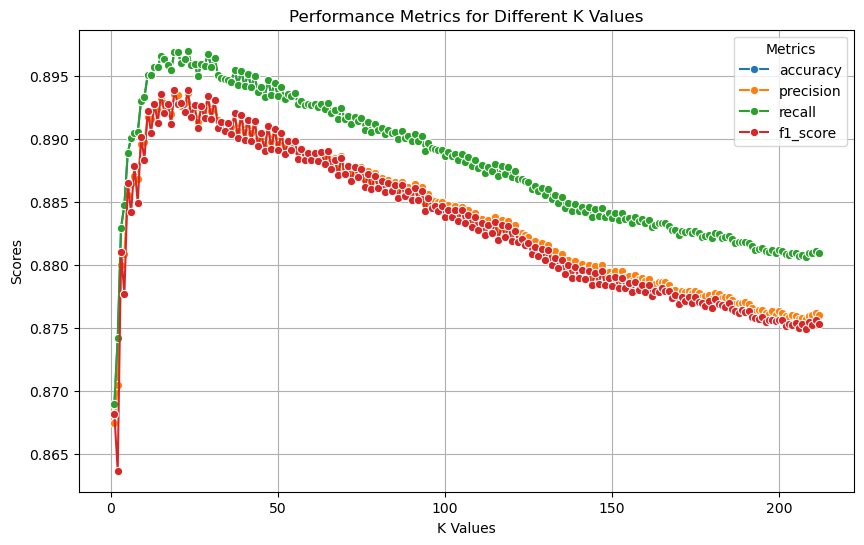

In [13]:
metrics = ['accuracy', 'precision', 'recall', 'f1_score']

plt.figure(figsize=(10, 6))

for metric in metrics:
    sns.lineplot(x=results_df['k'], y=results_df[metric], marker='o', label=metric)

# Customize the plot
plt.xlabel("K Values")
plt.ylabel("Scores")
plt.title("Performance Metrics for Different K Values")
plt.legend(title="Metrics")
plt.grid(True)
plt.show()


### Check Data Balance, which used to know if we will choose the k with highest f1_score or the highest accuracy, and as we see the data tend to be imbalanced as the two class are 77.77 and 22.22 percentage, so we tend to take the k with highest f1_score

In [82]:
unique_classes, class_counts = np.unique(y, return_counts=True)

class_distribution = pd.DataFrame({
    'Class': unique_classes,
    'Count': class_counts,
    'Percentage': (class_counts / len(y)) * 100
})

print(class_distribution)

threshold = 40  
is_imbalanced = (class_distribution['Percentage'] < threshold).any()

if is_imbalanced:
    print("The dataset is imbalanced.")
else:
    print("The dataset is balanced.")

   Class  Count  Percentage
0      0  34993    77.77432
1      1  10000    22.22568
The dataset is imbalanced.


### By normalizing the metrics to the range zero and one, all metrics are brought to the same scale, allowing for a fair combination, The combined score is calculated as the average of the normalized metrics, representing an aggregate measure of performance.Finally, the code identifies the value of 𝑘 that maximizes this combined score

In [18]:
results_df['normalized_accuracy'] = results_df['accuracy'] / results_df['accuracy'].max()
results_df['normalized_precision'] = results_df['precision'] / results_df['precision'].max()
results_df['normalized_recall'] = results_df['recall'] / results_df['recall'].max()
results_df['normalized_f1_score'] = results_df['f1_score'] / results_df['f1_score'].max()

results_df['combined_score'] = (
    results_df['normalized_accuracy'] +
    results_df['normalized_precision'] +
    results_df['normalized_recall'] +
    results_df['normalized_f1_score']
) / 4

highest_k = results_df.loc[results_df['combined_score'].idxmax(), 'k']

print(f"highest k value based on combined score: {highest_k}")


highest k value based on combined score: 23


### or as our classlabel is imbalanced, so we seek to get the k with highest F1_score

In [17]:
best_k = results_df.loc[results_df['f1_score'].idxmax(), 'k']

print(f"Best k value based on highest F1-score: {best_k}")

Best k value based on highest F1-score: 19


In [46]:
print(X_train)

[[0.13513514 1.         0.25       ... 0.17857143 0.73604061 0.        ]
 [0.25675676 1.         0.25       ... 0.53571429 0.70304569 1.        ]
 [0.22972973 1.         1.         ... 0.39285714 0.86548223 1.        ]
 ...
 [0.09459459 0.         1.         ... 0.10714286 0.67766497 0.        ]
 [0.09459459 1.         0.25       ... 0.17857143 0.76903553 0.        ]
 [0.02702703 0.         0.75       ... 0.         0.55076142 0.        ]]


### use the best choosen k and try with metric minkowski with p=2 (euclidean distance) and train the model with the x_train and y_train

In [83]:
classifier = KNeighborsClassifier(n_neighbors = 19, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=19)

### use the model to predict using the testing data, then print it and its coresponding actual y_test

In [84]:
y_pred = classifier.predict(X_test)
print(np.concatenate((y_pred.reshape(len(y_pred),1), y_test.reshape(len(y_test),1)),1))

[[0 1]
 [0 0]
 [0 0]
 ...
 [0 0]
 [1 1]
 [1 1]]


In [85]:
comparison = pd.DataFrame({
    'y_pred': y_pred,
    'y_test': y_test
})

print(comparison)

      y_pred  y_test
0          0       1
1          0       0
2          0       0
3          1       1
4          0       0
...      ...     ...
8994       0       0
8995       0       0
8996       0       0
8997       1       1
8998       1       1

[8999 rows x 2 columns]


### print the confusion matrix and other metric like accuracy, recall, precision and f1_score for evalution of KNN performance

In [86]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
# [[TN  FP]
#  [FN  TP]]


[[6683  276]
 [ 613 1427]]


In [87]:
tn, fp, fn, tp = cm.ravel()
print(f"True Negatives: {tn}")
print(f"False Positives: {fp}")
print(f"False Negatives: {fn}")
print(f"True Positives: {tp}")

True Negatives: 6683
False Positives: 276
False Negatives: 613
True Positives: 1427


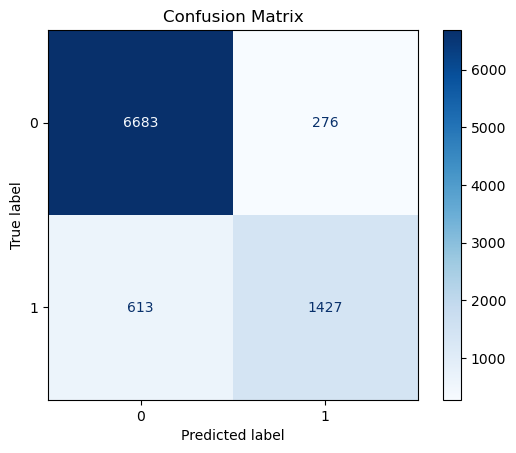

In [88]:
class_names = sorted(set(y_test))  
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=class_names, cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


In [89]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      6959
           1       0.84      0.70      0.76      2040

    accuracy                           0.90      8999
   macro avg       0.88      0.83      0.85      8999
weighted avg       0.90      0.90      0.90      8999



### make comparison between each matric distance and study which will result into more good metrics like f1_score and others, and after observing the results, manhatten and eclidean are slightly better than others distance as : Euclidean and Manhattan distances perform better when features are independent and not redundant. In high-dimensional data , other metrics like hamming can struggle because: it isn't suitable for high dimensional data and limited as the most of the dataset aren't binary or categorical. Manhattan distance is more robust in oure case because it sums individual feature differences

In [90]:
metrics = ['euclidean', 'manhattan', 'minkowski', 'chebyshev', 'hamming', 'cosine']
metric_results = []

for metric in metrics:
    knn = KNeighborsClassifier(n_neighbors=19, metric=metric)  
    knn.fit(X_train, y_train)

    y_test_pred = knn.predict(X_test)

    accuracy = accuracy_score(y_test, y_test_pred)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    metric_results.append({'metric': metric, 'accuracy': accuracy, 'precision': precision, 'recall': recall, 'f1_score': f1})


In [91]:
metric_comparison=pd.DataFrame(metric_results)
print(metric_comparison)

      metric  accuracy  precision    recall  f1_score
0  euclidean  0.901211   0.898288  0.901211  0.897932
1  manhattan  0.902767   0.899987  0.902767  0.899387
2  minkowski  0.901211   0.898288  0.901211  0.897932
3  chebyshev  0.895544   0.892187  0.895544  0.891901
4    hamming  0.840427   0.830310  0.840427  0.830945
5     cosine  0.899100   0.896153  0.899100  0.896527


### so i used the best metric distance and best k then i will use the grid search to optimize the model's performance 

In [92]:
knn = KNeighborsClassifier(n_neighbors=19, metric='manhattan')  
knn.fit(X_train, y_train)

KNeighborsClassifier(metric='manhattan', n_neighbors=19)

### the Hyperparameters here are settings for KNN model that are not learned during training .Hyperparameter tuning searches for the combination of hyperparameters that gives the best performance on the training data, using cross-validation

In [93]:
param_grid = {
    'weights': ['uniform', 'distance'], 
    'leaf_size': [20, 30, 40, 50],
}
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=KNeighborsClassifier(metric='manhattan', n_neighbors=19),
             param_grid={'leaf_size': [20, 30, 40, 50],
                         'weights': ['uniform', 'distance']})

### the weighted value Handles Imbalanced Data, Ensures classes with more samples have a fair impact, then check the improved F1_score and accuracy and other metrics.

In [94]:
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_
print("Best Parameters:", best_params)

# Evaluate the model on the test set
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_test_pred, average='weighted')
recall = recall_score(y_test, y_test_pred, average='weighted')
F_1 = f1_score(y_test, y_pred, average='weighted')
print("Test Set F1_score:", F_1)
print("Test Set Accuracy:", accuracy)
print("Test Set Recall:", recall)
print("Test Set precision:", precision)

Best Parameters: {'leaf_size': 20, 'weights': 'distance'}
Test Set F1_score: 0.9008526619441675
Test Set Accuracy: 0.9041004556061785
Test Set Recall: 0.8990998999888876
Test Set precision: 0.8961528441140358


In [95]:
comparison_after = pd.DataFrame({
    'y_pred': y_pred,
    'y_test': y_test
})

In [96]:
print(comparison_after)

      y_pred  y_test
0          0       1
1          0       0
2          0       0
3          1       1
4          0       0
...      ...     ...
8994       0       0
8995       0       0
8996       0       0
8997       1       1
8998       1       1

[8999 rows x 2 columns]
